In [1]:
from src.infer_models import infer
from src.preprocess import preprocess
from src.archs_models import *
from src.opts_models import perceptron_kernelizedbatch
import os
import sys
import pathlib
from pathlib import Path

import numpy as np
from numpy.core.shape_base import block
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"]})  # Avant Garde, Helvetica, Computer Modern Sans Serif
# for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"], # Times, Bookman, Pa;atino
# })
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "monospace",
#     "font.monospace": ["Consolas"],
# })

np.set_printoptions(precision=4)
np.set_printoptions(formatter={'float': "{:0.4f}".format})


# Ensure path is referenced to this script's root
# thisdir = os.path.dirname(__file__)
thisdir = Path.cwd()
# os.chdir(thisdir)
os.chdir(sys.path[0])
print(os.getcwd())

figs_dir = os.path.join(thisdir, 'figs/')
if not os.path.isdir(figs_dir):
    os.makedirs(figs_dir)

# os.chdir(r'./ai534ias/ia1/')

# Generate the path to the file relative to your python script:
# script_location = Path(__file__).absolute().parent
# print(script_location)
# file_location = script_location / 'file.yaml'
# file = file_location.open()


/home/somefunagba/ias/ia3


In [2]:
# Data Preprocessing

# do major feature engineering - 0 | 1
doengr = 0
donormalize = 1

# Train
rawdata = 'csvs/IA2-train.csv'
traindata, train_id = preprocess(rawdata, donormalize=donormalize, istrain=1,
                                 traininfo=None, doengr=doengr)

# View final data entering the model.
# print(traindata['X'])

# Dev
rawdata = 'csvs/IA2-dev.csv'
devdata, dev_id = preprocess(rawdata, donormalize=donormalize, istrain=0,
                             traininfo=traindata, doengr=doengr)


data size (rows,columns) (6000, 198)
                    Vehicle_Damage  Previously_Insured  Vehicle_Age_0  \
Vehicle_Damage            1.000000           -0.858465       0.305893   
Previously_Insured       -0.858465            1.000000      -0.313266   
Vehicle_Age_0             0.305893           -0.313266       1.000000   
Vehicle_Age_1            -0.418453            0.418906      -0.855960   
Vehicle_Age_2             0.177294           -0.164105      -0.348569   
Response                  0.598229           -0.583561       0.255089   

                    Vehicle_Age_1  Vehicle_Age_2  Response  
Vehicle_Damage          -0.418453       0.177294  0.598229  
Previously_Insured       0.418906      -0.164105 -0.583561  
Vehicle_Age_0           -0.855960      -0.348569  0.255089  
Vehicle_Age_1            1.000000      -0.186254 -0.341008  
Vehicle_Age_2           -0.186254       1.000000  0.133442  
Response                -0.341008       0.133442  1.000000  
data size (rows,columns)

In [3]:
# DEV: Model Training and Selection

# - max. number of iterations (fixed) - epochs
epochs = int(1e2)

# - learning-rate (step-size) selection set
# lrs =  [5e-3, 1e-2, 2e-2, 0.1, 0.5]
# learning rate
# stepsize = 1e-1

# - kernelized perceptron type
wt_types = ['averaged-online', 'online', 'batch']
# - poly degree
ps = [5]

# - zero weight initialization
#W = np.random.uniform(0, 0.02, (traindata['cols'], 1))
w_alpha = np.zeros(shape=(traindata['rows'], 1))

# Turns out lists and dicts are passed by ref. in python.
# They behave as global variables, modified in function they are passed to.

# list to hold all models
model_sels = []

wt_type = wt_types[2]
# for stepsize in lrs:
for p in ps:

    print(
        f'\n********** {wt_type}: kernelized order {p} - perceptron: ************************')
    print('(start):')
    # print(W.T) # to debug muatbility

    # - modeldict: data structure that holds details of the trained model
    modeldict = {'usekernel': 1, 'alphat': w_alpha.copy(), 'wtype': wt_type, 
                 'p': p, 'Xt': traindata["X"], 'Yt': traindata["Y"], 
                 'bndtype': 0,
                 'epochs': epochs, 'stepsize': None,
                 'cols': traindata['cols'],
                 'normalize': traindata['scalers'],
                 'mse_train': None, 'mse_dev': None,
                 }


    # - train: iterative line search (full batch)
    perceptron_kernelizedbatch(modeldict, sgnlinear_kernelized, traindata, devdata)


    model_sels.append(modeldict)

    print(f"Class Accuracy (Train): {modeldict['facc_train'][-1]:2.4f} | "
          f"(Validation): {modeldict['facc_dev'][-1]:2.4f}")
    # print(W.T)
    print('(end): ----\n')



********** batch: kernelized order 5 - perceptron: ************************
(start):
k:     0, facc(train): 0.7370, facc(dev): 0.7392
k:    10, facc(train): 0.7508, facc(dev): 0.7339
k:    20, facc(train): 0.7775, facc(dev): 0.7640
k:    30, facc(train): 0.7867, facc(dev): 0.7722
k:    40, facc(train): 0.7912, facc(dev): 0.7654
k:    50, facc(train): 0.7918, facc(dev): 0.7748
k:    60, facc(train): 0.7995, facc(dev): 0.7671
k:    70, facc(train): 0.7920, facc(dev): 0.7745
k:    80, facc(train): 0.8163, facc(dev): 0.7516
k:    90, facc(train): 0.8213, facc(dev): 0.7491
Class Accuracy (Train): 0.8213 | (Validation): 0.7491
(end): ----



Perceptron Variant Plot...	


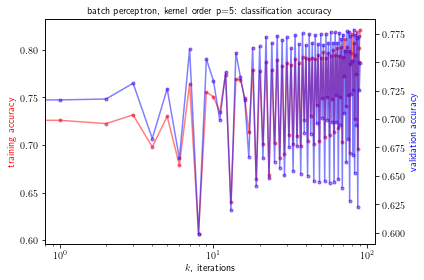

Done.



In [4]:

# Plots
for mdl in model_sels:
    print('Perceptron Variant Plot...\t')
    fig, ax3 = plt.subplots(figsize=(6, 4), tight_layout=True)
    ax3.semilogx(mdl['facc_train'],
                 color='r', marker='.', markerfacecolor='m', alpha=0.5)
    ax3.set_ylabel(f'training accuracy', color='r')
    ax4 = ax3.twinx()
    ax4.semilogx(mdl['facc_dev'],
                 color='b', marker='.', markerfacecolor='m', alpha=0.5)
    ax4.set_ylabel(f'validation accuracy', color='b')
    ax3.set_xlabel(f'$k$, iterations')
    ax3.set_title(f"{mdl['wtype']} perceptron, kernel order p={mdl['p']}: classification accuracy",
                  color='k', weight='bold', size=10)
    # plt.ion
    plt.savefig(
        figs_dir + f"P2b{mdl['wtype']}_kernelperceptron_plt{mdl['p']}.pdf", bbox_inches='tight')
    plt.show(block=False)
    print('Done.\n')
